In [ ]:
# !pip install requests
# !pip install pandas
# !pip install matplotlib


  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl (8.1 MB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.61.1-cp311-cp311-win_amd64.whl (2.3 MB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl (7.0 MB)
     -------------------------------------- 121.8/121.8 kB 2.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests

def fetch_json(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [32]:
# url = "http://192.168.0.109:8080/get?gyrX=full&gyrY=full&gyrZ=full&accX=full&accY=full&accZ=full"
url = url = "http://192.168.0.109:8080/get"
data = fetch_json(url)
print(data)
# print(data["buffer"].keys())


{'buffer': {}, 'status': {'session': 'b83456', 'measuring': False, 'timedRun': False, 'countDown': 0}}


In [ ]:
import pandas as pd
import time
df = pd.read_csv("air_gesture_data.csv")
print(df)

In [52]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os

# ==============================
# CONFIGURATION
# ==============================
PHY_PHOX_URL = (
    "http://192.168.1.11:8080/get?gyrX=full&gyrY=full&gyrZ=full&accX=full&accY=full&accZ=full"
)

OUTPUT_CSV = "gesture_dataset_2.csv"

SAMPLING_RATE = 100        # Hz (same as phyphox)
DIGIT_LABEL = 5            # <-- change per recording

Z_DOWN_THRESHOLD = -7.0
Z_UP_THRESHOLD = 7.0
WINDOW_SIZE = 5            # consecutive samples


# ==============================
# ExTRACT SERIES
# ==============================
def extract_series(buffer):
    """
    phyphox format:
    buffer = [[v1, v2, v3, ...]]
    We want:
    [v1, v2, v3, ...]
    """
    if isinstance(buffer, list) and len(buffer) == 1:
        return buffer[0]
    return buffer


# ==============================
# FETCH DATA
# ==============================
def fetch_phyphox_data():
    response = requests.get(PHY_PHOX_URL, timeout=10)
    response.raise_for_status()
    return response.json()["buffer"]


# ==============================
# PARSE DATA
# ==============================
def parse_sensor_data(raw):
    # print(raw["buffer"])
     # Find common length
    acc_x = extract_series(raw["accX"]["buffer"])
    acc_y = extract_series(raw["accY"]["buffer"])
    acc_z = extract_series(raw["accZ"]["buffer"])

    gyro_x = extract_series(raw["gyrX"]["buffer"])
    gyro_y = extract_series(raw["gyrY"]["buffer"])
    gyro_z = extract_series(raw["gyrZ"]["buffer"])
    min_len = min(
        len(acc_x), len(acc_y), len(acc_z),
        len(gyro_x), len(gyro_y), len(gyro_z)
    )
    df = pd.DataFrame({
        "acc_x": acc_x[:min_len],
        "acc_y": acc_y[:min_len],
        "acc_z": acc_z[:min_len],
        "gyro_x": gyro_x[:min_len],
        "gyro_y": gyro_y[:min_len],
        "gyro_z": gyro_z[:min_len],
    })
    return df


# ==============================
# ADD TIME COLUMN
# ==============================
def add_time(df):
    df["time"] = np.arange(len(df)) / SAMPLING_RATE
    return df


# ==============================
# TRIM USING FLIP
# ==============================
def trim_gesture(df):
    down = df["acc_z"] < Z_DOWN_THRESHOLD
    up = df["acc_z"] > Z_UP_THRESHOLD

    down_confirm = down.rolling(WINDOW_SIZE).sum() >= WINDOW_SIZE
    up_confirm = up.rolling(WINDOW_SIZE).sum() >= WINDOW_SIZE

    if not down_confirm.any():
        raise ValueError("❌ Flip DOWN not detected")

    start_idx = down_confirm.idxmax()

    up_after = up_confirm.loc[start_idx + 1:]
    if not up_after.any():
        raise ValueError("❌ Flip UP not detected")

    end_idx = up_after.idxmax()

    return df.loc[start_idx:end_idx].reset_index(drop=True)


# ==============================
# SAVE CSV
# ==============================
def save_csv(df):
    # df["label"] = DIGIT_LABEL
    # df["trial_id"] = datetime.now().strftime("%Y%m%d_%H%M%S")

    write_header = not os.path.exists(OUTPUT_CSV)
    df.to_csv(OUTPUT_CSV, mode="a", index=False, header=write_header)


# ==============================
# MAIN
# ==============================
def main():
    print("📡 Fetching phyphox data...")
    raw = fetch_phyphox_data()

    print("📊 Parsing sensor buffers...")
    df = parse_sensor_data(raw)

    print("⏱️ Creating timestamps...")
    df = add_time(df)

    print("✂️ Trimming gesture...")
    gesture_df = trim_gesture(df)
    
    print("💾 Writing to CSV...")
    save_csv(gesture_df)

    print("✅ Done!")
    print("Saved rows:", len(gesture_df))


if __name__ == "__main__":
    main()


📡 Fetching phyphox data...
📊 Parsing sensor buffers...
⏱️ Creating timestamps...
✂️ Trimming gesture...
💾 Writing to CSV...
✅ Done!
Saved rows: 100


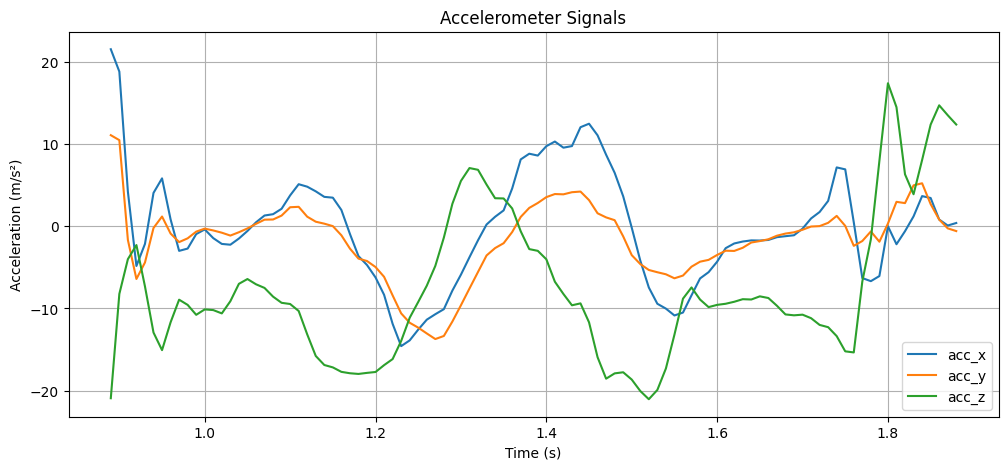

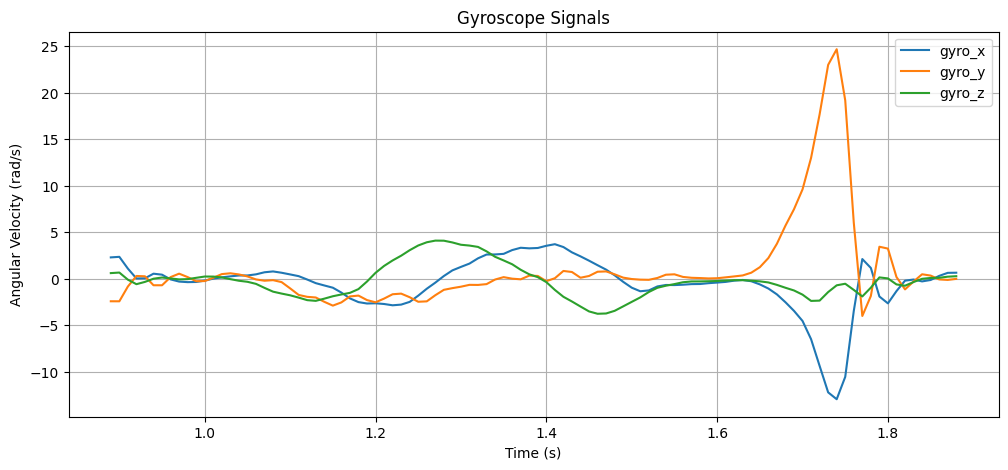

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_FILE = "gesture_dataset_2.csv"  # change path

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_FILE)

time = df["time"]

# =========================
# PLOT ACCELEROMETER
# =========================
plt.figure(figsize=(12, 5))
plt.plot(time, df["acc_x"], label="acc_x")
plt.plot(time, df["acc_y"], label="acc_y")
plt.plot(time, df["acc_z"], label="acc_z")

plt.title("Accelerometer Signals")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# PLOT GYROSCOPE
# =========================
plt.figure(figsize=(12, 5))
plt.plot(time, df["gyro_x"], label="gyro_x")
plt.plot(time, df["gyro_y"], label="gyro_y")
plt.plot(time, df["gyro_z"], label="gyro_z")

plt.title("Gyroscope Signals")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import os
DATASET_DIR = "Dataset"
os.listdir(DATASET_DIR)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

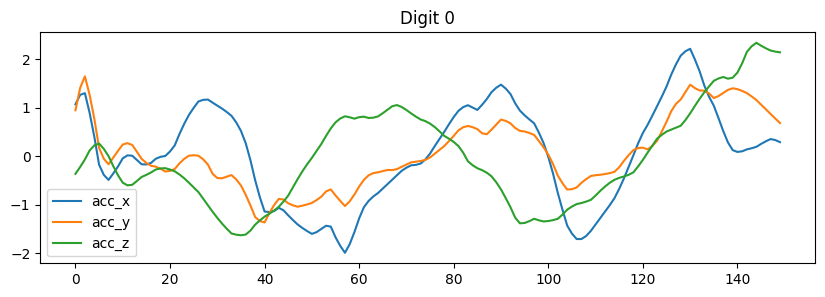

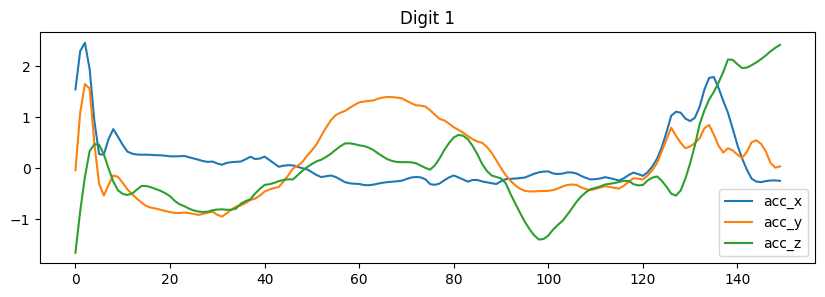

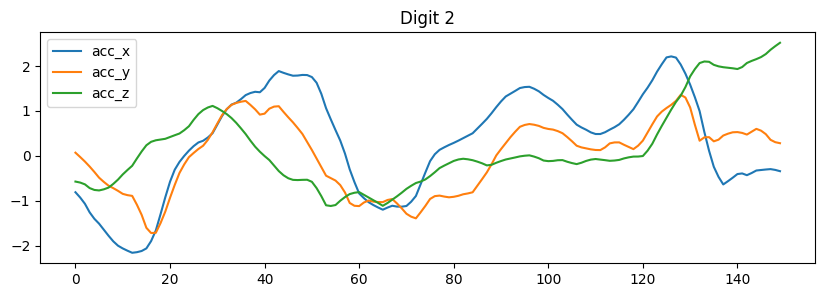

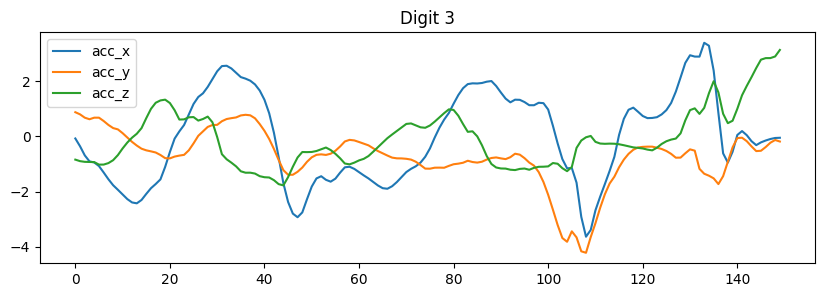

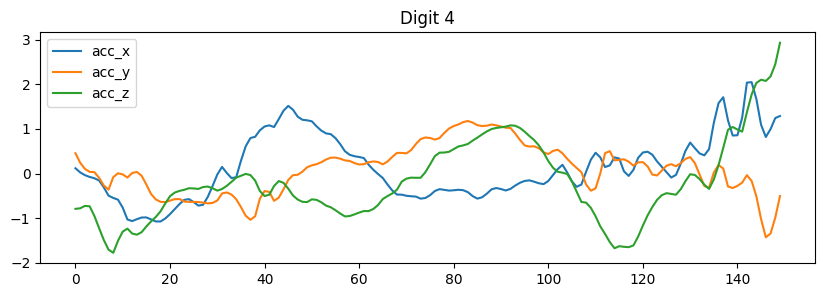

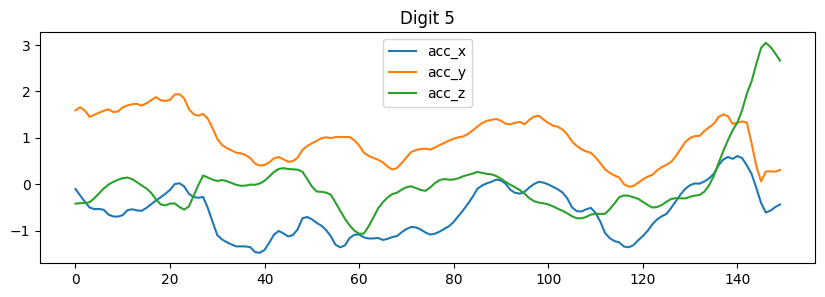

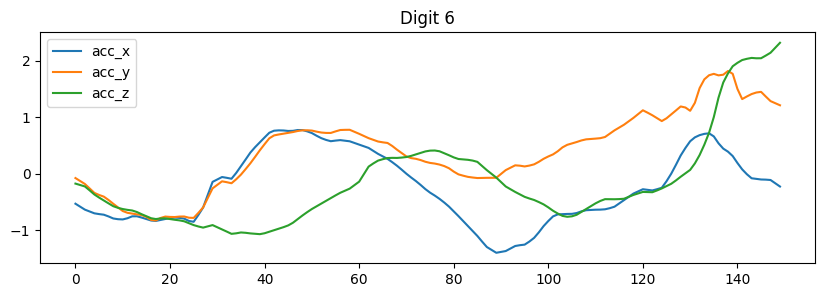

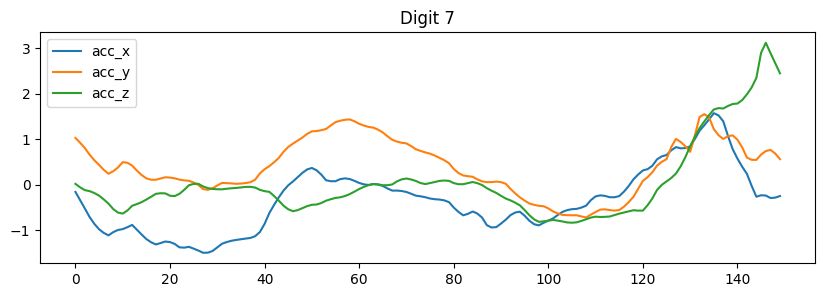

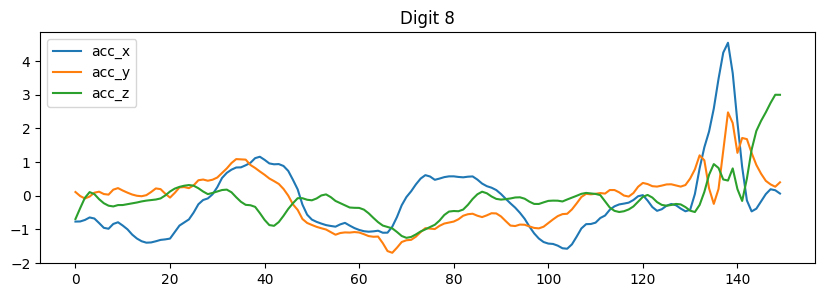

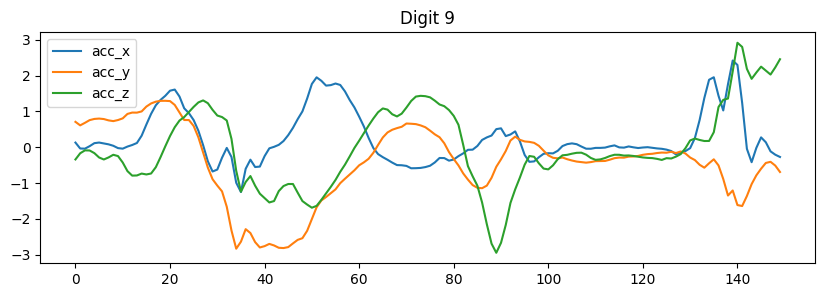

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.load("processed/X_train.npy")
y = np.load("processed/y_train.npy")

for digit in range(10):
    idx = np.where(y == digit)[0][0]
    sample = X[idx]

    plt.figure(figsize=(10,3))
    plt.plot(sample[:,0], label="acc_x")
    plt.plot(sample[:,1], label="acc_y")
    plt.plot(sample[:,2], label="acc_z")
    plt.title(f"Digit {digit}")
    plt.legend()
    plt.show()
